<h1>Melanoma Detection using CNN : Part-2</h1>
<h2>Modelling and Inference</h2>

---

A typical deep learning pipeline involves the following steps-

1. Preparing the data so that it can be used for training/inference. This involves creating custom datasets/dataloaders so that batches of data can be fed to the model.

\***NOTE**- *A general best practice is to split the training data set into training and validation sets, then training using only the training set at first, while using the validaton set for inference to test the model's performance. This gives a rough idea on how efficiently the model will perform on the test set.*

2. Defining a model that will be used for training/inference. This step involves either using pretrained models, or creating a custom neural network from scratch.

3. Once the model is defined, we need to define helper functions for model training. A typical training epoch involves the following operations-
    * Forward propagation, where we use the model to predict the target values for a given training data. Then we use a criterion (loss function) to compare the predicted values against the actual target values and calculate the total information loss.
    * Back propagation, where we calculate the gradients of the model parameters w.r.t. the total loss, then use an optimizer function to update the weights and biases accordingly.
    * There is also an optional validation step where we evaluate the model performance on the validation data using the updated model parameters.****
---

## Preparing the Dataset
---

In this section, we will define the dataset and dataloaders. Let us begin with importing all the necessary project dependencies.

In [1]:
import os
import torch
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid

Let's now load the training and testing dataframes.

In [2]:
train_df = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [3]:
test_df = pd.read_csv('../input/siim-isic-melanoma-classification/test.csv')
test_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


Now that we have loaded the testing and training dataframes, let's create the custom PyTorch dataset objects that will allow us to use the image data with our PyTorch model.

In [4]:
# creating custom pytorch dataset
class ImageDataset(Dataset):
    """Converts the images into a dataset that will allow us to use the image data with our model
    
    Args-
        dataframe- pandas.DataFrame object containing image IDs and labels
        data_dir- The directory in which the images are located
        transforms- torchvision.transforms methods to apply transformations on the images
        test- Boolean value, denotes whether the data is training or testing data
    """
    def __init__(self, dataframe, data_dir, transform = None, test = False):
        self.df = dataframe
        self.data_dir = data_dir
        self.transform = transform
        self.test = test
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        if self.test:
            img_name = self.df.loc[idx]['image_name']
        else:
            img_name, label = self.df.loc[idx][['image_name','target']]
        
        img_path = self.data_dir + '/' + img_name + '.jpg'
        img = Image.open(img_path)
        
        if self.transform:
            img = self.transform(img)
        if self.test:
            return img 
        else:
            return img, label

Now that we have defined our custom dataset class. Just one more step before we create our datasets. If you notice carefully, the images aren't of a consistent size. We need to perform a few transformations on the images like resizing and center-cropping.

Let us define the transformations. We will experiment with a few sets of transformations and see which ones give us the best result.

In [5]:
transform_1 = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
])

Now let us create our datasets.

In [6]:
# path of training data image directory
train_dir = '../input/siim-isic-melanoma-classification/jpeg/train'

# path of test data image directory
test_dir = '../input/siim-isic-melanoma-classification/jpeg/test'

#creating training dataset object
train_dataset = ImageDataset(train_df, train_dir, transform = transform_1, test = False)

#creating training dataset object
test_dataset = ImageDataset(test_df, test_dir, transform = transform_1, test = True)

Let us test our ImageDataset objects by printing the lengths of both the test set and the training set.

In [7]:
len(train_dataset), len(test_dataset)

(33126, 10982)

Now, let us view some random images from our training and test datasets.

In [8]:
def image_viewer(dataset, index):
    """Shows image in the dataset at the index that the user provides.
    
    Args-
        dataset- the custom dataset object
        index- index of the image
    Returns-
        None
    """
    label_dict = {0: 'Benign', 1: 'Malignant'}
    try:
        image, label = dataset[index]
        print('Lesion type:', label_dict[label])
    except:
        image = dataset[index]
    
    plt.imshow(image.permute(1,2,0))

Lesion type: Benign


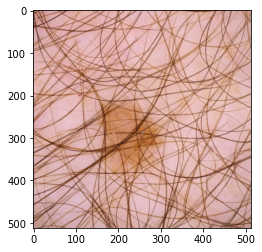

In [9]:
image_viewer(train_dataset, 69)

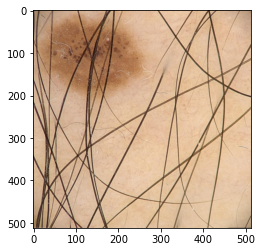

In [10]:
image_viewer(test_dataset, 420)

NOw that we know that our datasets are working fine, let us move to the next step. We need to split the training dataset into training and validation datasets. We will keep the validation set around 10% of the complete training dataset.

In [11]:
val_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size

train_split_ds, val_split_ds = random_split(train_dataset, lengths = [train_size, val_size])

Let us have a look at the number of instances in both our train and validation splits.

In [12]:
len(train_split_ds), len(val_split_ds) 

(29814, 3312)

Now, we need to define a method so that during the training/inference, the data is moved to the CUDA device (Nvidia GPU) in batches instead of all at once. This is very important since our dataset is huge and if we try to move the entire data to the GPU at once, it will run out of memory and we'll run into an error.

In [24]:
batch_size = 16
                                                                                
train_dl = DataLoader(
    dataset = train_split_ds, 
    batch_size = batch_size, 
    shuffle = True, 
    num_workers = 2, 
    pin_memory = True)

val_dl = DataLoader(
    dataset = val_split_ds, 
    batch_size = batch_size, 
    shuffle = False, 
    num_workers = 2, 
    pin_memory = True)

We have defined the dataloaders. Now, let's view a batch of data.

In [27]:
def batch_viewer(dataloader):
    """Shows the images in a batch of data
    
    Args-
        dataloader- PyTorch dataloader object
    
    Returns-
        None
    """
    for images, labels in dataloader:
        fig, ax = plt.subplots(figsize = (16,16))
        ax.imshow(make_grid(images, nrow = 4).permute(1, 2, 0))
        break  

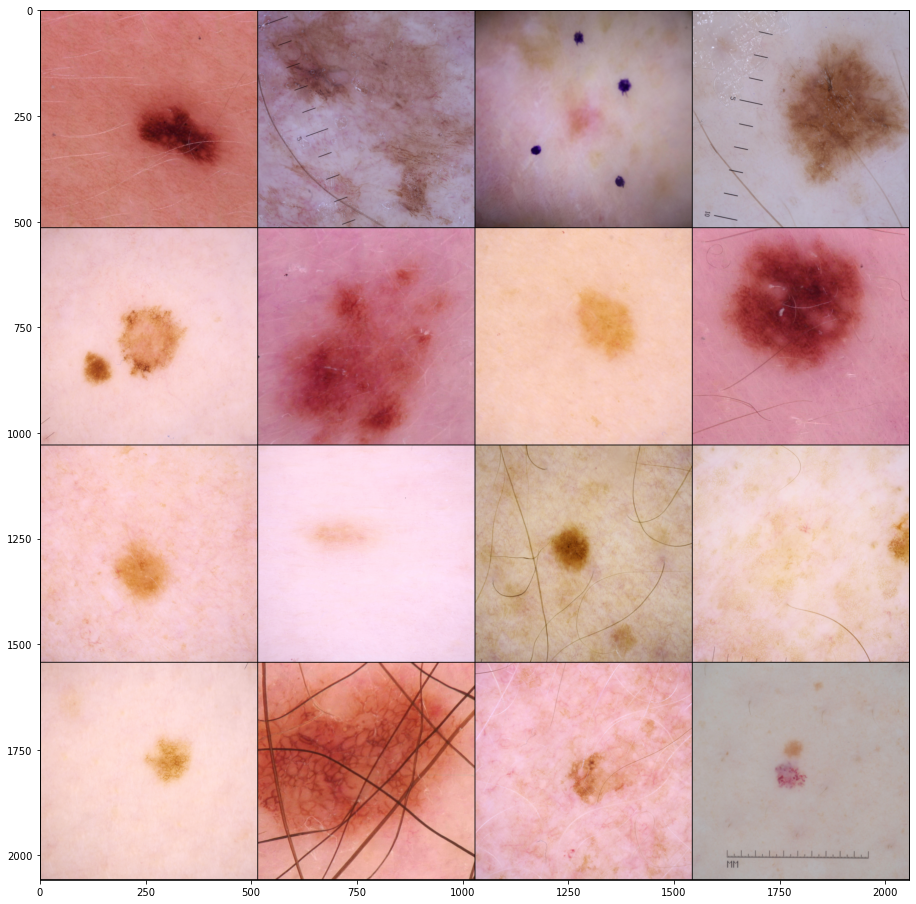

In [26]:
batch_viewer(train_dl)